# Data challenge

This Juypter notebook is Part 1 of 2, and contains all data exploration and cleaning steps taken for Project Arm Data Challenge. **The goal is to build a model for predicting a matrix of percents/proportions**.

In [1]:
# begin by importing all necessary libraries for this notebook:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# for inline plotting:

%matplotlib inline

# seems like the FutureWarnings I'm getting are a bug so ignore

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The data come in two separate files, one containing the multiple target variables, and the other containing the features. **Note that the features do not have descriptive names in the file**.

In [2]:
# import the targets Y and features X
# omit the first column in each since it's not necessary

Y = pd.read_csv('data_challenege_output.csv').iloc[:,1:]
X = pd.read_csv('data_challenege_input.csv').iloc[:,1:]

# give the (non-descriptive) features better names

X.columns = ["var" + str(i) for i in range(1,26)]
Y.columns = ['x','y','z']

The targets are contained in a $(46598 \times 3)$ matrix---there are 46,598 observations and 3 targets. There are 25 features associated with these observations:

In [3]:
Y.shape
X.shape

Y.head(2)
X.head(2)

(46598, 3)

(46598, 25)

,x,y,z
0,100.000000,0.000000,0.0
1,42.578826,57.421174,0.0


,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25
0,2,19.75,3,6,0.0,194.276,0.001,5.412,0.000000,0.0000,...,0.194276,4,0.097138,0.291414,296.25,19.75,316.0,296.444276,19.847138,316.291414
1,1,2.00,2,9,36.0,180.115,0.001,3.901,0.001177,0.0057,...,0.900575,2,0.090057,0.990633,1.60,0.40,2.0,2.500575,0.490057,2.990632


# Exploring the targets

As a first step, let's take a look at a pairs plot for the targets. Histograms for each individual target are on the diagonal, and pairwise scatterplots are on the off diagonal. 

Looking at the histograms, it seems that there's a *very* high number of observations at or very near 0% and 100%. Target X favors 100% slightly; Target Y heavily favors 0%; Target Z is almost entirely all 0%. For Targets X and Y, the distribution between 0% and 100% is essentially uniform.

From the scatterplots, 

Two important considerations:
1. **The high number of observations at the tail ends of the distribution might be problematic**
2. **There is very little variability present in Target Z**

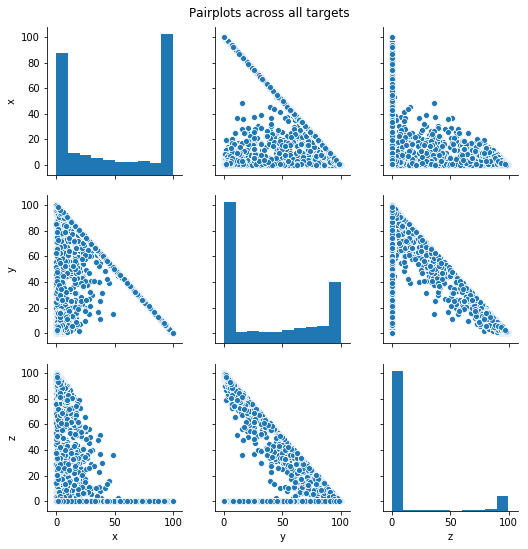

In [4]:
# Correlogram of target variables
# Univariate histograms on the diagonal, and
# Pairwise scatterplots on the off diagonal

sns.pairplot(Y)
plt.suptitle('Pairplots across all targets', y=1.01);

The correlations among the targets are all negative, but note that they're likely biased due to the harsh lines at 0%. 

In [5]:
# correlation matrix of observed targets

round(Y.corr(),2)

,x,y,z
x,1.00,-0.75,-0.42
y,-0.75,1.00,-0.29
z,-0.42,-0.29,1.00


In [6]:
#a = round(Y['x']) == 0
#b = round(Y['x']) == 100
#round(round(Y['x'])[a | b].value_counts() / 46598,2)

#a = round(Y['y']) == 0
#b = round(Y['y']) == 100
#round(round(Y['y'])[a | b].value_counts() / 46598,2)

#a = round(Y['z']) == 0
#b = round(Y['z']) == 100
#round(round(Y['z'])[a | b].value_counts() / 46598,2)

## Transformations of the targets

Since the target variables we're predicting are percents, I'm interested in three transformations that I might explore in the modeling stage:
1. A simple transformation from percents to proportions. Data on this scale $[0,1]$ would be useful for a beta regression, which could work here. 
2. These proportions can then be further transformed via the logit function, to be on the log-odds or logits scale. Since this scale is in the range $(-\infty, \infty)$, we can fit it to a linear regression model. This is essentially like a logistic regression.
3. Finally, can discretize the original targets by rounding each to the nearest integer. Now the targets look like count variables on the range $[0,100]$. This might be useful for a zero-inflated, truncated (at 100) Poisson regression.

**Transform percents to proportions:**

In [7]:
# transform percents to be proportions

Y_prop = Y * 0.01

Y_prop.head()

,x,y,z
0,1.000000,0.000000,0.0
1,0.425788,0.574212,0.0
2,1.000000,0.000000,0.0
3,1.000000,0.000000,0.0
4,1.000000,0.000000,0.0


**Transform proportions to logits:**

For the logit transformation, will need to feed proportions from Y_prop through the logit function: $\text{logit}(p) = \ln(p) - \ln(1-p)$, which I write a little helper function for. One problem, though, is that proportions of exactly 0 and 1 will not work (undefined solution). To get around this, I add and subtract a little noise to 0s and 1s, respectively. The noise is defined as half of the minimum value of each target. 

In [8]:
# helper function which adjusts cases of 0 or 1

def logit_adjust(var):
    adjust = min(Y_prop[var][Y_prop[var] > 0]) / 2
    new_var = np.where(Y_prop[var] == 0, Y_prop[var] + adjust,
        np.where(Y_prop[var] == 1, Y_prop[var] - adjust, Y_prop[var]))
    return new_var

# helper function which transforms proportions to logit scale

def logit(p):
    return np.log(p) - np.log(1 - p)

# create dataframe of Y on the logit scale

Y_logit = pd.DataFrame({'x': logit(logit_adjust(var = 'x')), 
                        'y': logit(logit_adjust(var = 'y')), 
                        'z': logit(logit_adjust(var = 'z'))})

Y_logit.head()

,x,y,z
0,9.935396,-7.526587,-6.195833
1,-0.299056,0.299056,-6.195833
2,9.935396,-7.526587,-6.195833
3,9.935396,-7.526587,-6.195833
4,9.935396,-7.526587,-6.195833


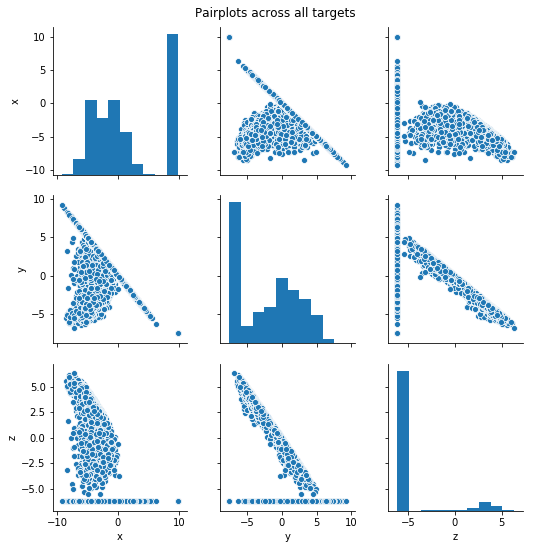

In [9]:
# Correlogram of target variables
# Univariate histograms on the diagonal, and
# Pairwise scatterplots on the off diagonal

sns.pairplot(Y_logit)
plt.suptitle('Pairplots across all targets', y=1.01);

**Transform percents to integers:**

In [10]:
# transform percents to be proportions

Y_int = round(Y)

Y_int.head()

,x,y,z
0,100.0,0.0,0.0
1,43.0,57.0,0.0
2,100.0,0.0,0.0
3,100.0,0.0,0.0
4,100.0,0.0,0.0


Combine the different versions of the targets into one dataframe:

In [11]:
# combine dataframes

Y_all = pd.concat([Y, Y_prop, Y_logit, Y_int], axis = 1, ignore_index = False)

# rename column names to be descriptive

Y_all.columns = ['xOrig','yOrig','zOrig',
                'xProp','yProp','zProp',
                'xLogit','yLogit','zLogit',
                'xInt','yInt','zInt']

Y_all.head()

,xOrig,yOrig,zOrig,xProp,yProp,zProp,xLogit,yLogit,zLogit,xInt,yInt,zInt
0,100.000000,0.000000,0.0,1.000000,0.000000,0.0,9.935396,-7.526587,-6.195833,100.0,0.0,0.0
1,42.578826,57.421174,0.0,0.425788,0.574212,0.0,-0.299056,0.299056,-6.195833,43.0,57.0,0.0
2,100.000000,0.000000,0.0,1.000000,0.000000,0.0,9.935396,-7.526587,-6.195833,100.0,0.0,0.0
3,100.000000,0.000000,0.0,1.000000,0.000000,0.0,9.935396,-7.526587,-6.195833,100.0,0.0,0.0
4,100.000000,0.000000,0.0,1.000000,0.000000,0.0,9.935396,-7.526587,-6.195833,100.0,0.0,0.0


# Split data into train/test sets

To evaluate the predictive models, I split the full dataset into training and test subsets. Given the large number of observations, I'll use a 60%-40% (train-test, respectively) split. Before performing the split, I look for duplicates to remove. 

## Assess extent of duplicates

Interestingly, of the 46,598 total observations in the features dataframe, ~53% (or 24,622 observations) come up as duplicates.

In [12]:
print('Duplicated observations:', X.duplicated().sum())
print('Percent of data that are duplicates:', round(X.duplicated().sum() / 46598 * 100,1))

Duplicated observations: 24622
Percent of data that are duplicates: 52.8


Next, I combine the targets with the features to see if these duplicates still emerge. The same number of duplicates appear, which suggests that these observations are duplicates across both features and targets, and duplicated instances should therefore be removed. 

In [13]:
# combine train/test sets by stacking

YX = pd.concat([Y_all, X], axis = 1)

print('Duplicated observations:', YX.duplicated().sum())

Duplicated observations: 24622


To address this, I'll keep the first instance of the duplicated cases, and get rid of the rest. I'll have to separate the target and features into new dataframes. Ultimately, I end up with 21,976 final observations. 

In [14]:
# remove duplicates, keep the first instance of the duplicated cases

YX = YX.drop_duplicates(keep = 'first')

# how many rows do we have now?

YX.shape

# save the updated target and features separately

Y_all, X = YX.iloc[:,0:12], YX.iloc[:,12:]

(21976, 37)

## Perform split

Final training and test sets includes 13,185 and 8,791 observations, respectively.

In [15]:
# perform train-test split where test size
# is 40% of total observations

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y_all, test_size = 0.4, random_state = 12011,
    shuffle = True)

X_train.shape 
X_test.shape
Y_train.shape
Y_test.shape

(13185, 25)

(8791, 25)

(13185, 12)

(8791, 12)

# Exploring the features

## Assess extent of missingness

No missing data found in the features.

In [16]:
# look for missingness in features

X_train.isnull().sum()[X_train.isnull().sum() > 0]
X_test.isnull().sum()[X_train.isnull().sum() > 0]

Series([], dtype: int64)

Series([], dtype: int64)

## Look for constants

To make exploring the features a little easier, I look at their data types (dtype) and save the features by dtype. 

Looks like the features were all read in as numeric data, with 21 as float64 (continuous) and 4 as int64 (integer) data type. None are constants, but the int64 features could actually be coded values that represent nominal features so I'm also pulling up the number of unique values for each feature. I want to take a closer look at those with fewer than ~50 unique values.

In [17]:
# data types across features

X_train.dtypes.value_counts()

# number of unique values, sorted 

X_train.nunique().sort_values()

float64    21
int64       4
dtype: int64

var1        11
var17       13
var12       16
var3        25
var2        27
var7        46
var11       54
var4        94
var14      184
var13      236
var15      240
var5       246
var20      357
var21      453
var9       463
var10      485
var22      522
var18     9650
var24     9690
var8     10565
var6     13009
var16    13085
var19    13109
var23    13144
var25    13151
dtype: int64

In [18]:
# save a list of feature names by dtype

int_features = list(X_train.select_dtypes(include = ['int64']).columns.values)
float_features = list(X_train.select_dtypes(include = ['float64']).columns.values)

int_features
float_features

['var1', 'var3', 'var4', 'var17']

['var2',
 'var5',
 'var6',
 'var7',
 'var8',
 'var9',
 'var10',
 'var11',
 'var12',
 'var13',
 'var14',
 'var15',
 'var16',
 'var18',
 'var19',
 'var20',
 'var21',
 'var22',
 'var23',
 'var24',
 'var25']

## Closer look at features

### Summary of training data

Let's take a look at a quick and dirty summary of our (training) data, as well as histograms to get a visual sense of their distribution. A few key points are apparent:
- All 25 features are pretty heavily right-skewed, with a large spike in observations around zero. **Might consider transforming. One snag is that 14 of 25 features have 0 as a true value. Another transformation for those?**
- The scale across features is *very* different (e.g., the min/max of var7 & var6 are 0.00/0.47 and 13/2915). **I'll need standardize these eventually to get them onto a more comparable scale.**
- Some of the features (e.g., var12/var3), though numeric, show signs of binning. **Might consider discretizing some of these features.**

In [19]:
## recombine Y and X from training set together into one
YX_train = pd.concat([Y_train, X_train], axis = 1)

## summary table
X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
var1,13185.0,1.026925,3.657863,0.000000,0.000000,1.000000,1.000000,183.000000
var2,13185.0,3.516686,3.852741,0.000000,2.000000,3.000000,4.000000,41.500000
var3,13185.0,1.854987,1.960949,1.000000,1.000000,1.000000,2.000000,28.000000
var4,13185.0,12.695411,11.123237,1.000000,4.000000,9.000000,17.000000,140.000000
var5,13185.0,26.389685,26.909094,0.000000,7.000000,24.000000,36.000000,349.000000
var6,13185.0,377.231424,344.344913,13.007000,109.479000,254.501000,554.452000,2915.272000
var7,13185.0,0.005695,0.007685,0.000000,0.000000,0.002000,0.009000,0.047000
var8,13185.0,31.721639,42.141103,0.149000,2.691000,9.658000,51.075000,340.115000
var9,13185.0,0.003142,0.004789,0.000000,0.000000,0.000749,0.004548,0.037664
var10,13185.0,0.008825,0.003904,0.000000,0.006300,0.008200,0.010750,0.046850


In [20]:
X[["var" + str(i) for i in range(1,13)]].head()
X[["var" + str(i) for i in range(13,26)]].head()

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12
0,2,19.75,3,6,0.0,194.276,0.001,5.412,0.000000,0.00000,0.016,0.001
1,1,2.00,2,9,36.0,180.115,0.001,3.901,0.001177,0.00570,0.005,0.005
2,1,2.00,1,4,0.0,130.985,0.001,3.832,0.000000,0.00390,0.002,0.003
3,1,3.00,1,4,7.0,64.321,0.000,1.202,0.000000,0.00495,0.003,0.001
4,1,2.00,1,4,7.0,102.304,0.000,2.897,0.000000,0.00575,0.004,0.003


,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25
0,0.000000,15.000000,1.000000,0.194276,4,0.097138,0.291414,296.250000,19.750000,316.000000,296.444276,19.847138,316.291414
1,1.000000,0.800000,0.200000,0.900575,2,0.090057,0.990633,1.600000,0.400000,2.000000,2.500575,0.490057,2.990632
2,0.666667,0.333333,0.333333,0.392955,2,0.065492,0.458448,0.666667,0.666667,1.333333,1.059622,0.732159,1.791781
3,3.000000,3.000000,0.000000,0.064321,2,0.000000,0.064321,9.000000,0.000000,9.000000,9.064321,0.000000,9.064321
4,1.333333,1.333333,0.000000,0.306912,2,0.000000,0.306912,2.666667,0.000000,2.666667,2.973579,0.000000,2.973579


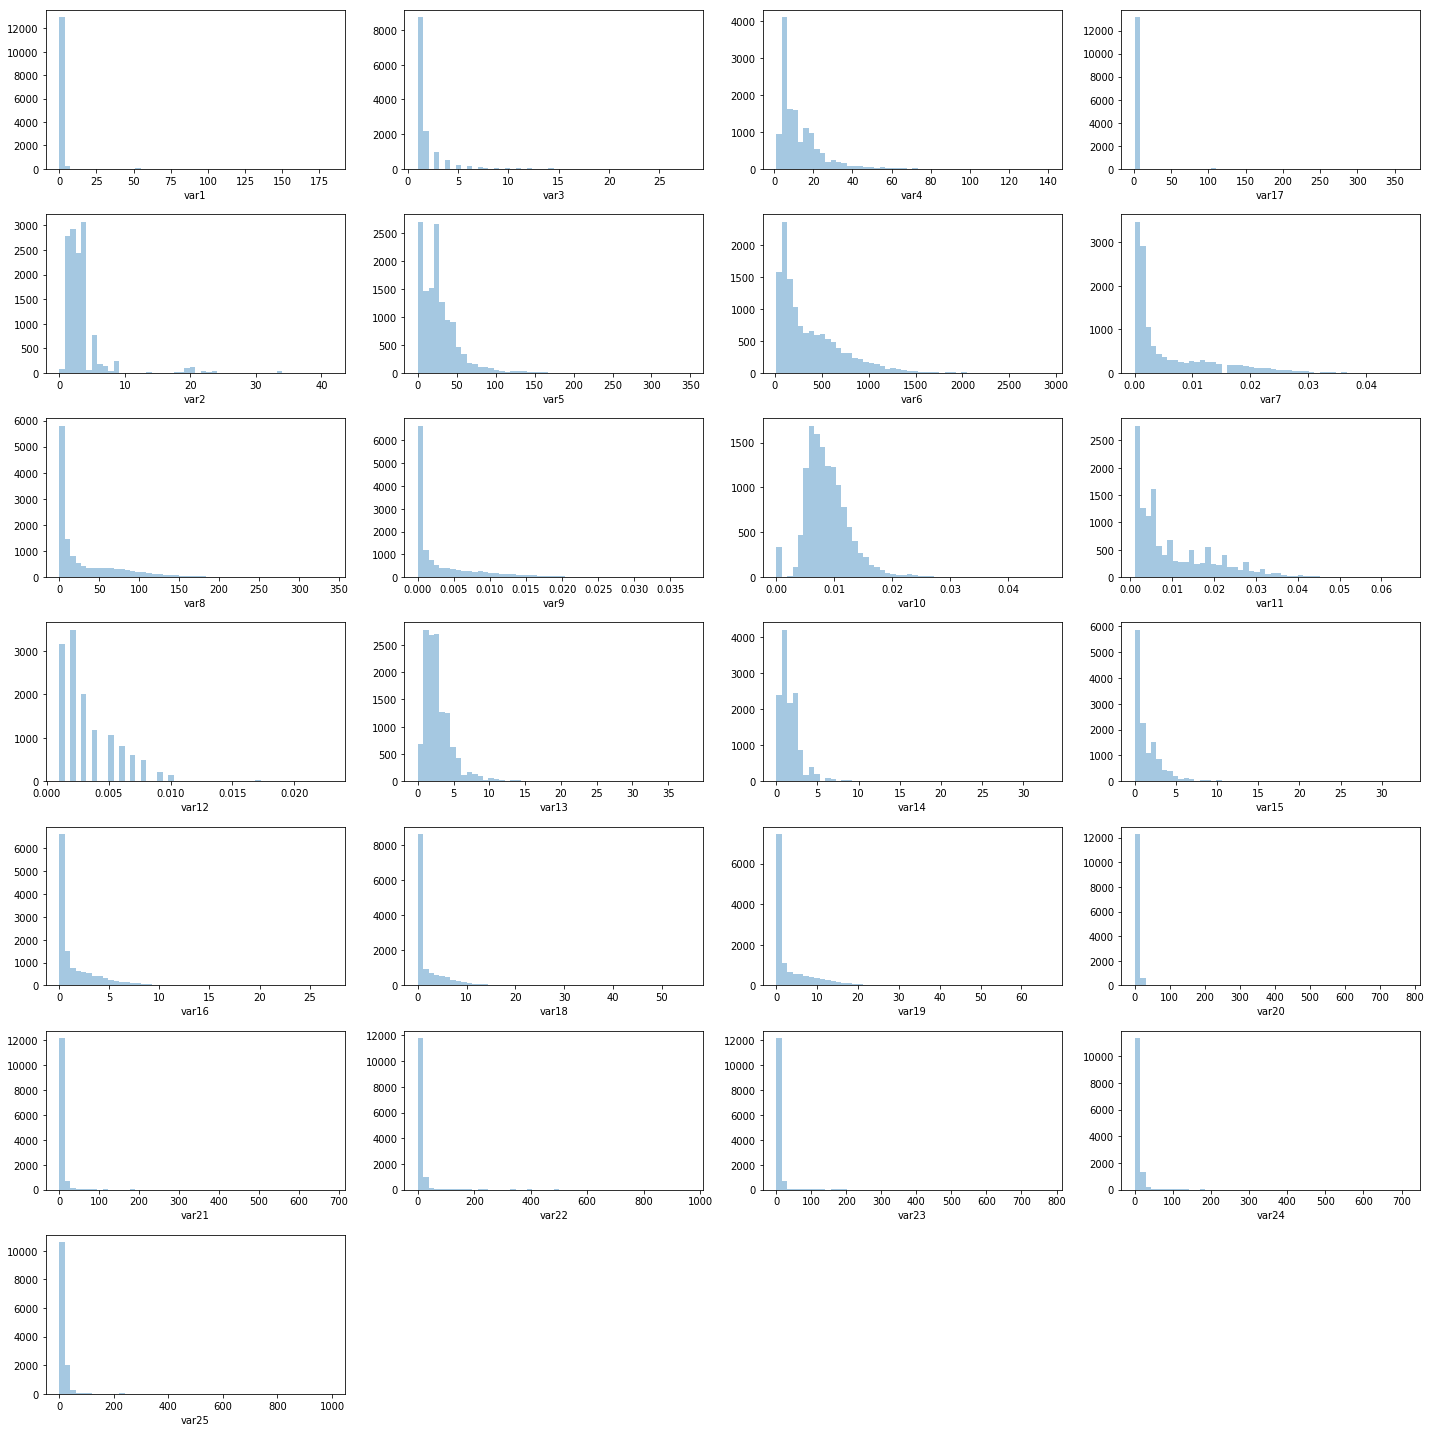

In [21]:
# i want to show them by dtype so create temp. variable

_ = int_features + float_features

# print 25 histograms

plt.figure(figsize=(20,20))
for i in range(1,26):
    plt.subplot(7,4,i)
    sns.distplot(X_train[_[i-1]], kde=False)

plt.tight_layout();

### Examine correlations

Next, let's take a look at associations of features with the targets, and among the features themselves using a correlation matrix, and heatmap. A few considerations:
- The 3 targets are negatively correlated with one another. This is expected since having more of one target means you have less than the others. 
- Several of the features have very low correlations with the targets. For example, vars 1,2,3,10,17,20,22, and 23 don't have correlation values that exceed 0.1 (rounded to the nearest tenth) for any of the targets. **If I don't discretize them, I might consider dropping them altogether, especially if they're highly intercorrelated.**
- 6 different pairs of features have correlation values that exceed $|0.95|$---vars (1 & 17); (7 & 8); (18 & 19); (20 & 23); (21 & 24); (22 & 25). **Might consider dropping one of the pairs.**

,xProp,yProp,zProp,var1,var2,var3,var4,var5,var6,var7,...,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25
xProp,1.000,-0.713,-0.450,0.045,0.092,-0.094,-0.561,-0.492,-0.611,-0.707,...,-0.553,0.026,-0.558,-0.582,0.015,-0.179,-0.098,-0.035,-0.241,-0.164
yProp,-0.713,1.000,-0.306,0.005,0.004,0.146,0.328,0.412,0.460,0.197,...,0.318,0.014,0.246,0.287,0.033,0.145,0.104,0.062,0.170,0.136
zProp,-0.450,-0.306,1.000,-0.067,-0.130,-0.058,0.343,0.144,0.243,0.709,...,0.346,-0.053,0.444,0.425,-0.063,0.058,0.001,-0.032,0.110,0.050
var1,0.045,0.005,-0.067,1.000,0.055,-0.037,-0.078,-0.054,-0.060,-0.074,...,0.079,0.998,-0.060,-0.007,0.035,0.020,0.030,0.042,0.012,0.029
var2,0.092,0.004,-0.130,0.055,1.000,0.026,-0.055,-0.029,-0.080,-0.141,...,-0.233,0.048,-0.110,-0.165,0.648,0.557,0.675,0.631,0.526,0.647
var3,-0.094,0.146,-0.058,-0.037,0.026,1.000,0.736,0.736,0.479,0.109,...,0.350,-0.031,0.235,0.293,0.197,0.129,0.181,0.230,0.154,0.213
var4,-0.561,0.328,0.343,-0.078,-0.055,0.736,1.000,0.856,0.815,0.631,...,0.693,-0.062,0.687,0.722,0.112,0.217,0.189,0.175,0.294,0.270
var5,-0.492,0.412,0.144,-0.054,-0.029,0.736,0.856,1.000,0.691,0.416,...,0.535,-0.042,0.481,0.526,0.107,0.183,0.165,0.156,0.236,0.224
var6,-0.611,0.460,0.243,-0.060,-0.080,0.479,0.815,0.691,1.000,0.759,...,0.839,-0.039,0.852,0.887,0.062,0.244,0.178,0.138,0.340,0.278
var7,-0.707,0.197,0.709,-0.074,-0.141,0.109,0.631,0.416,0.759,1.000,...,0.759,-0.051,0.897,0.884,-0.037,0.186,0.091,0.031,0.289,0.192


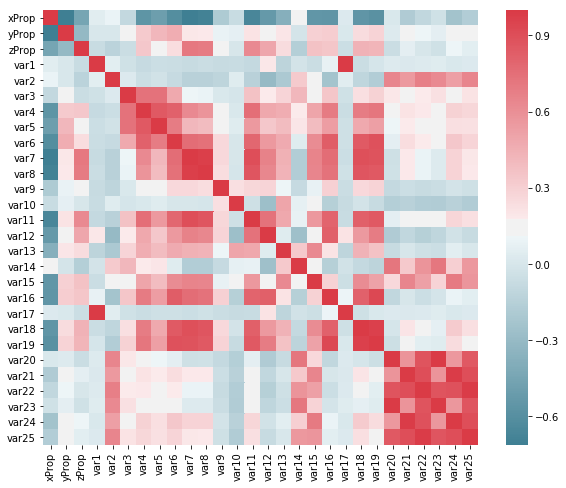

In [22]:
# Keep only the proportion targets

_ = list(YX_train.filter(regex='Orig')) + list(YX_train.filter(regex='Logit')) + list(YX_train.filter(regex='Int'))
_ = YX_train[YX_train.columns.drop(_)]

## correlation plot

f, ax = plt.subplots(figsize=(10, 8))
corr = _.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax);

round(corr, 3)

In [23]:
## let's look at the highest intercorrelations

corr_matrix = X_train.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
sol[sol >= 0.95]

var1   var17    0.997716
var20  var23    0.995938
var22  var25    0.993309
var21  var24    0.992866
var7   var8     0.974827
var18  var19    0.971679
dtype: float64

# Feature engineering

## Discretizing variables

Below I show the proportion of observations in the training data that fall across the values in those variables with fewer than 46 values. These, though numeric, might benefit from being discretized. Few points:
- For most of these features, the overwhelming majority of the observations fall into the first 2-4 lowest values (e.g., over 90% of the observations fall in values 0/1/2 for var1) **Might be beneficial to discretize these features**


In [24]:
# look at categories in those with < 50 unique values

_ = ['var1','var17','var12','var2','var3','var7']

#for i in _:
#    print(X_train[i].unique())
    
for i in _:
    print(round(X_train[i].value_counts() / 13185 * 100, 4))    
    

1      52.1274
0      33.9401
2      10.6409
4       1.6534
3       1.3349
54      0.2275
64      0.0379
105     0.0152
183     0.0076
87      0.0076
41      0.0076
Name: var1, dtype: float64
1      33.9401
2      29.8749
3      22.2526
4       9.8218
8       1.6534
6       1.3349
5       0.8191
109     0.2275
128     0.0379
211     0.0152
175     0.0076
366     0.0076
82      0.0076
Name: var17, dtype: float64
0.002    26.3860
0.001    23.8604
0.003    15.2977
0.004     8.8661
0.005     8.0774
0.006     6.1509
0.007     4.4975
0.008     3.6481
0.009     1.6458
0.010     1.1756
0.017     0.2655
0.011     0.0910
0.020     0.0152
0.023     0.0076
0.018     0.0076
0.015     0.0076
Name: var12, dtype: float64
4.00     23.3447
2.00     22.2374
1.00     21.1528
3.00     18.5135
5.00      5.9234
9.00      1.6534
6.00      1.3955
7.00      1.1301
20.00     0.8495
19.75     0.7205
0.00      0.5612
4.50      0.4020
33.25     0.3261
23.50     0.3185
22.25     0.3110
7.50      0.1972
22.50     0.1

Scatterplots showing each feature against each of the three targets can also illuminate a need to discretize, and give us insight into the utility of the 25 features. Few points:
- Even if we discretize some of the features, the proportions are pretty uniformly distributed across the values they would take. For example, discretizing var1 would not really show a relationship between its categorical version and any of the three targets. **Without more information about the features, I'm inclined to leave them as-is. If they're useless, then a robust modeling approach will just suppress them (e.g., via regularization)**.

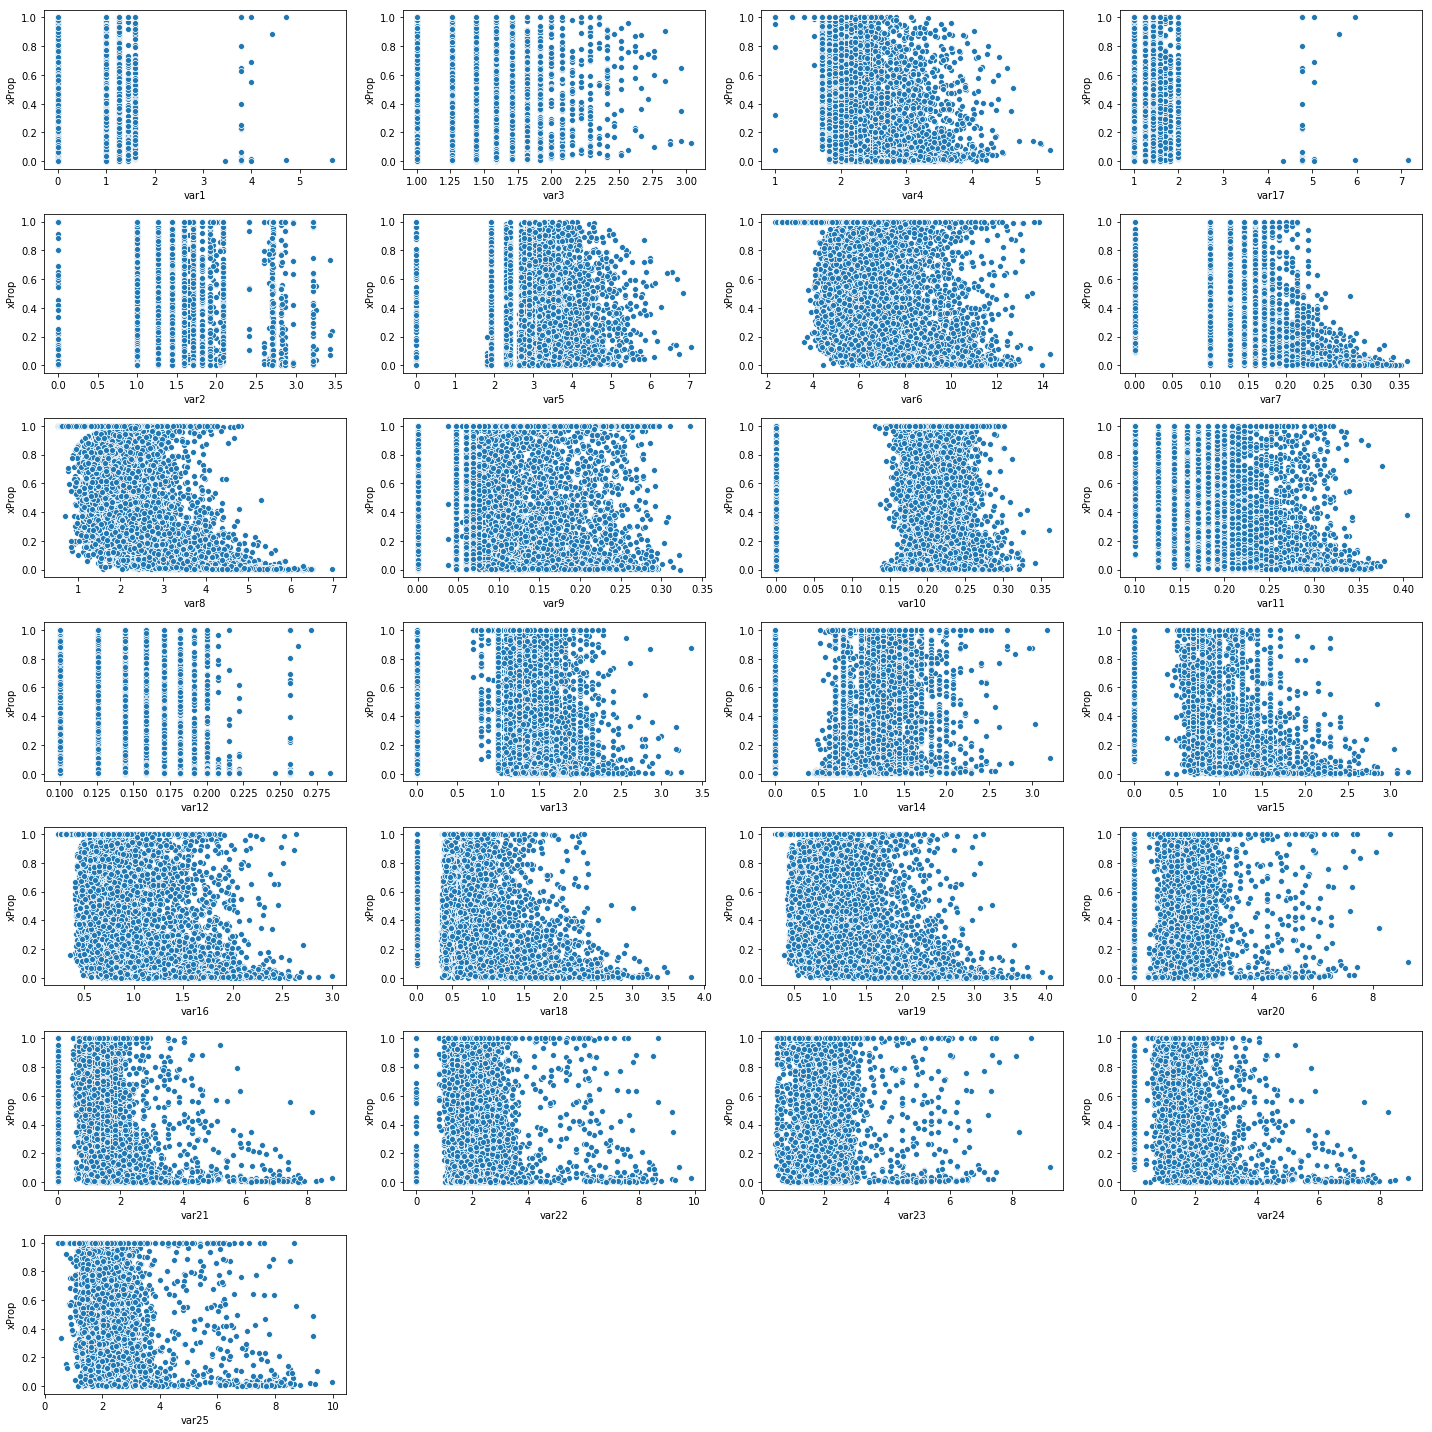

In [25]:
# scatterplot of feature against xProp

_ = int_features + float_features

plt.figure(figsize=(20,20))
for i in range(1,26):
    plt.subplot(7,4,i)
    sns.scatterplot(np.cbrt(X_train[_[i-1]]), Y_train['xProp'])

plt.tight_layout();

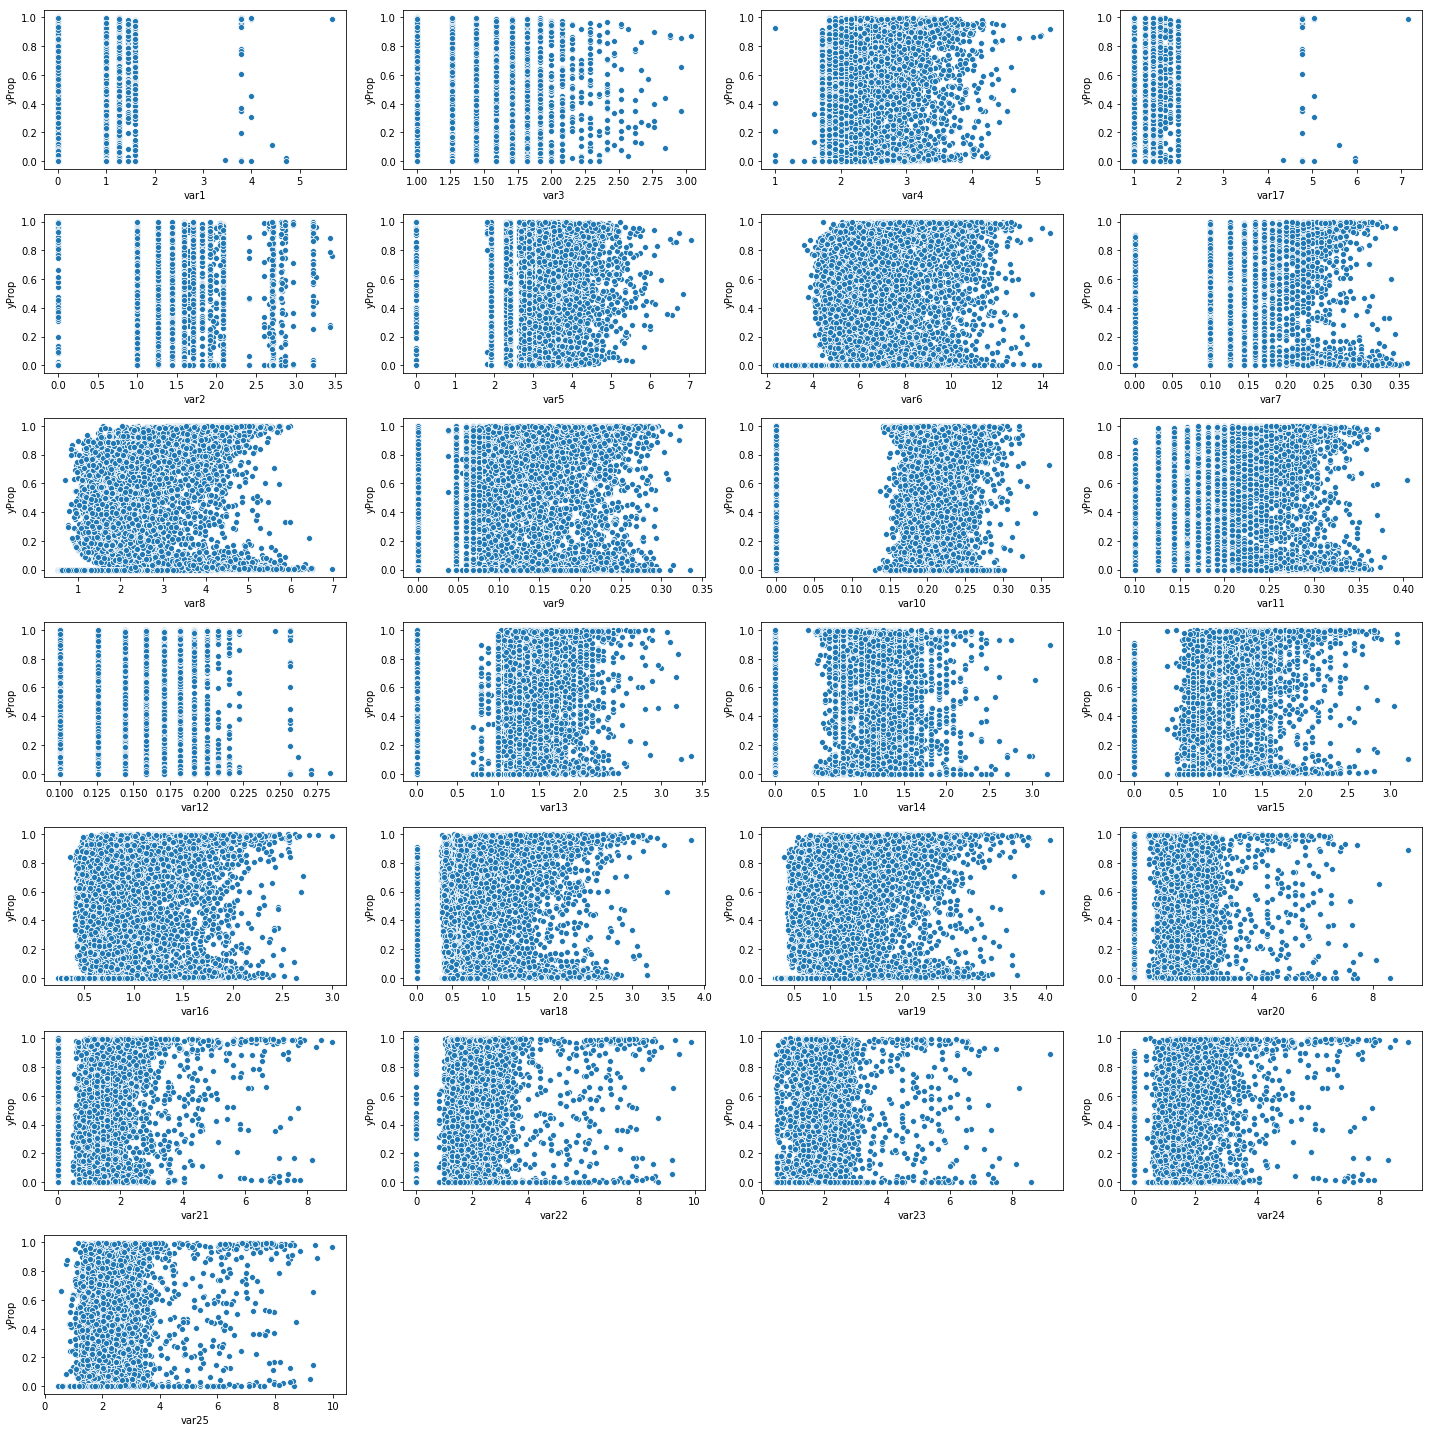

In [26]:
# scatterplot of feature against yProp

_ = int_features + float_features

plt.figure(figsize=(20,20))
for i in range(1,26):
    plt.subplot(7,4,i)
    sns.scatterplot(np.cbrt(X_train[_[i-1]]), Y_train['yProp'])

plt.tight_layout();

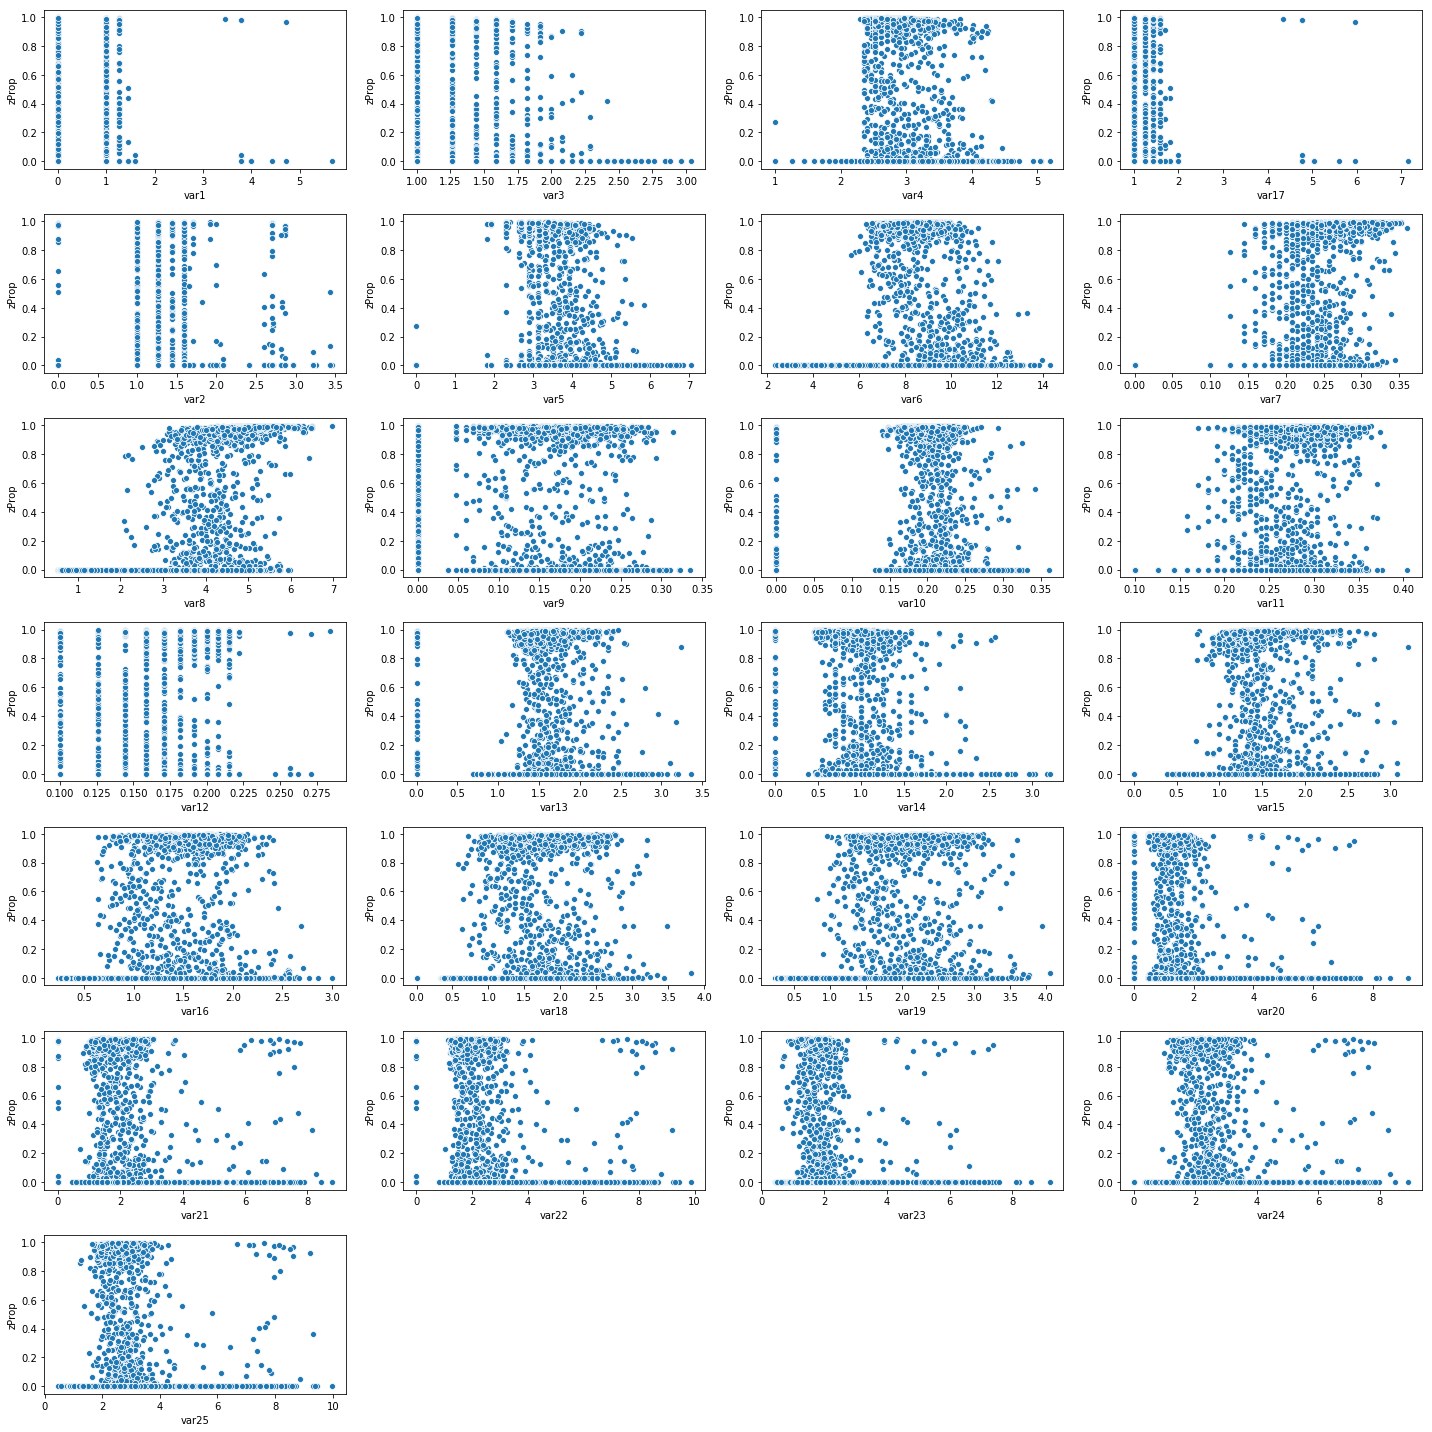

In [27]:
# scatterplot of feature against zProp

_ = int_features + float_features

plt.figure(figsize=(20,20))
for i in range(1,26):
    plt.subplot(7,4,i)
    sns.scatterplot(np.cbrt(X_train[_[i-1]]), Y_train['zProp'])

plt.tight_layout();

## Dropping features

What *is* clear from the above plots is that the pairs of features with high interdependency $r>0.95$ have nearly the same relationship with the targets, and one of the pairs should therefore be dropped. Var1, var18, var20, var21, var22 will be dropped.

In [28]:
# drop variables

X_train = X_train.drop(columns=['var1','var18','var20','var21','var22'])
X_test = X_test.drop(columns=['var1','var18','var20','var21','var22'])

# rename using consecutive numbers

X_train.columns = ["var" + str(i) for i in range(1,21)]
X_test.columns = ["var" + str(i) for i in range(1,21)]

## Standardizing features

In [29]:
scale = StandardScaler()

# change the int64 to float64, otherwise, sklearn will yell

X_train['var2'] = X_train['var2'].astype(float)
X_train['var3'] = X_train['var3'].astype(float)
X_train['var16'] = X_train['var16'].astype(float)

X_test['var2'] = X_test['var2'].astype(float)
X_test['var3'] = X_test['var3'].astype(float)
X_test['var16'] = X_test['var16'].astype(float)

# fit_transform for training set, but only transform test set

X_train_adj = scale.fit_transform(X_train)

X_test_adj = scale.transform(X_test)

In [30]:
# save datasets

with open("final_adj_armDataChallenge.pickle", "wb") as f:
    pickle.dump((X_train_adj,Y_train,X_test_adj,Y_test), f)

In [32]:
YX

,xOrig,yOrig,zOrig,xProp,yProp,zProp,xLogit,yLogit,zLogit,xInt,...,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25
0,100.000000,0.000000,0.000000,1.000000,0.000000,0.000000,9.935396,-7.526587,-6.195833,100.0,...,0.194276,4,0.097138,0.291414,296.250000,19.750000,316.000000,296.444276,19.847138,316.291414
1,42.578826,57.421174,0.000000,0.425788,0.574212,0.000000,-0.299056,0.299056,-6.195833,43.0,...,0.900575,2,0.090057,0.990633,1.600000,0.400000,2.000000,2.500575,0.490057,2.990632
2,100.000000,0.000000,0.000000,1.000000,0.000000,0.000000,9.935396,-7.526587,-6.195833,100.0,...,0.392955,2,0.065492,0.458448,0.666667,0.666667,1.333333,1.059622,0.732159,1.791781
3,100.000000,0.000000,0.000000,1.000000,0.000000,0.000000,9.935396,-7.526587,-6.195833,100.0,...,0.064321,2,0.000000,0.064321,9.000000,0.000000,9.000000,9.064321,0.000000,9.064321
4,100.000000,0.000000,0.000000,1.000000,0.000000,0.000000,9.935396,-7.526587,-6.195833,100.0,...,0.306912,2,0.000000,0.306912,2.666667,0.000000,2.666667,2.973579,0.000000,2.973579
5,100.000000,0.000000,0.000000,1.000000,0.000000,0.000000,9.935396,-7.526587,-6.195833,100.0,...,0.170868,4,0.000000,0.170868,6.000000,0.000000,6.000000,6.170868,0.000000,6.170868
6,0.786731,3.760228,95.453041,0.007867,0.037602,0.954530,-4.837140,-3.242363,3.044176,1.0,...,3.324096,1,11.218824,14.542920,4.500000,13.500000,18.000000,7.824096,24.718824,32.542920
7,100.000000,0.000000,0.000000,1.000000,0.000000,0.000000,9.935396,-7.526587,-6.195833,100.0,...,1.255284,2,0.104607,1.359891,2.000000,0.333333,2.333333,3.255284,0.437940,3.693224
8,100.000000,0.000000,0.000000,1.000000,0.000000,0.000000,9.935396,-7.526587,-6.195833,100.0,...,0.149436,3,0.000000,0.149436,12.000000,0.000000,12.000000,12.149436,0.000000,12.149436
9,2.761795,97.238205,0.000000,0.027618,0.972382,0.000000,-3.561283,3.561283,-6.195833,3.0,...,5.992572,2,6.991334,12.983906,6.333333,4.666667,11.000000,12.325905,11.658001,23.983906
